In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 

In [2]:
from pathlib import Path
from typing import List, Optional, Sequence, Union, Any, Callable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Subset

from torchvision.datasets import CelebA

class MyCelebA(CelebA):    
    def _check_integrity(self) -> bool:
        return True

class VAEDataset(Dataset):
    def __init__(
        self,
        data_path: str = 'celeba',
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256), # the size of the crop to take from the original images.
        num_workers: int = 0,
        pin_memory: bool = False, # whether prepared items should be loaded into pinned memory or not. This can improve performance on GPUs.
        **kwargs,):
        
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        
    def setup(self, stage: Optional[str] = None) -> None:
        train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(self.patch_size),
                                              transforms.ToTensor(),])
        
        val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.patch_size),
                                            transforms.ToTensor(),])
        
        self.train_dataset = MyCelebA(
            self.data_dir,
            split='train',
            transform=train_transforms,
            download=False,
        )
        
        self.train_dataset = Subset(self.train_dataset, range(1000))
        
        # Replace CelebA with your dataset
        self.val_dataset = MyCelebA(
            self.data_dir,
            split='test',
            transform=val_transforms,
            download=False,
        )
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

In [5]:
vae_data = VAEDataset()
vae_data.setup()
train_data = vae_data.train_dataloader()

In [6]:
dataiter = iter(train_data)
image, label = next(dataiter)

In [7]:
image.shape #batch, channels(RGB), dim, dim

torch.Size([8, 3, 256, 256])

In [8]:
#residual block - pass input directly without any processing
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False))
        
    def forward(self, x):
        
        return x + self.resblock(x)

In [80]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        modules = []
        modules.append(nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(128, 256, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(256, 512, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(512*32*32, latent_dim) 
        self.fc_var = nn.Linear(512*32*32, latent_dim)
        
    def forward(self, x):
        result = self.encoder(x)
        result_ = torch.flatten(result, start_dim=1) 
        mu = self.fc_mu(result_)
        log_var = self.fc_var(result_)
        return mu, log_var
    
    
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [81]:
latent_dim = 128 
encoder = Encoder(latent_dim)

mu, logvar = encoder(image)
z = reparameterize(mu, logvar)
print(z.shape)

torch.Size([8, 128])


In [86]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder_input = nn.Linear(latent_dim, 512*32*32)
        
        modules = []
        modules.append(nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
                      nn.Tanh()))
        self.decoder = nn.Sequential(*modules)
        

    def forward(self, z):
        decoder_inp = self.decoder_input(z)
        decoder_inp = decoder_inp.view(decoder_inp.size(0), 512, 32, 32)
        result = self.decoder(decoder_inp)
        return result

In [87]:
latent_dim = 128 
decoder = Decoder(latent_dim)

result = decoder(z)
print(result.shape)

torch.Size([8, 3, 256, 256])


In [88]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = encoder(x)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [89]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [90]:
latent_dim = 128
epochs = 12
learning_rate = 1e-3

vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [91]:
from tqdm import tqdm


for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_data)):
        data = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_data.dataset):.4f}')

125it [01:43,  1.21it/s]


Epoch 1, Loss: 0.0397


125it [01:48,  1.15it/s]


Epoch 2, Loss: 0.0384


125it [02:07,  1.02s/it]


Epoch 3, Loss: 0.0382


125it [02:04,  1.00it/s]


Epoch 4, Loss: 0.0380


125it [01:53,  1.10it/s]


Epoch 5, Loss: 0.0379


125it [02:00,  1.04it/s]


Epoch 6, Loss: 0.0380


125it [01:55,  1.09it/s]


Epoch 7, Loss: 0.0379


125it [01:37,  1.28it/s]


Epoch 8, Loss: 0.0379


125it [01:29,  1.40it/s]


Epoch 9, Loss: 0.0378


125it [01:31,  1.36it/s]


Epoch 10, Loss: 0.0379


125it [01:34,  1.32it/s]


Epoch 11, Loss: 0.0379


125it [01:41,  1.24it/s]

Epoch 12, Loss: 0.0378


In [92]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=8):
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].axis('off')
    plt.show()
    
    

vae.eval()
dataiter = iter(train_data)
image, label = next(dataiter)

reconstructed, _, _ = vae(image)

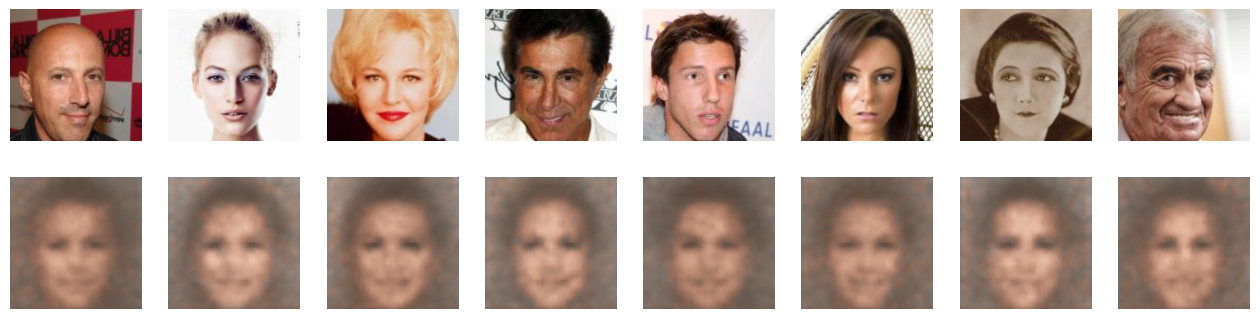

In [93]:
show_images(image, reconstructed)